# 1. Project Topic

This is the notebook for [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview). The task of this project is to predict whether tweets indicate disaster or not. 

**Target**

The target of this project is to achieve **F1 score > 0.8 by RNN** in Kaggle Score. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.initializers import glorot_uniform
from sklearn.metrics import f1_score

# 2. Data

The train data has 7613 samples, and the test data has 3263 samples. Only train data has label `target`. Both train and test data have `text`, `keyword`, and `location`.

**Data Source**

https://www.kaggle.com/competitions/nlp-getting-started/data

In [4]:
train_path = "/kaggle/input/nlp-getting-started/train.csv"
test_path = "/kaggle/input/nlp-getting-started/test.csv"
sample_path = "/kaggle/input/nlp-getting-started/sample_submission.csv"
sample_df = pd.read_csv(sample_path)
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
n_train = train_df.shape[0]
n_test = test_df.shape[0]

In [5]:
print("train data size", train_df.shape)
print("test data size", test_df.shape)

train data size (7613, 5)
test data size (3263, 4)


In [6]:
train_df.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [7]:
test_df.head(3)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


# 3. EDA

## 3.1 Label

This train data is almost balanced (43% positive). 

In [8]:
print(np.round(train_df["target"].mean(), 2)*100, "% of label is positive" )

43.0 % of label is positive


Text(0.5, 1.0, 'Histogram of label')

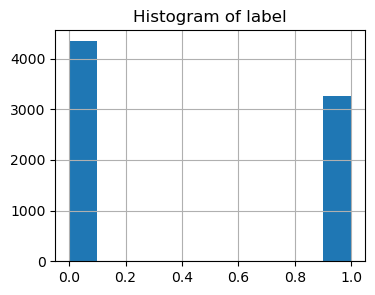

In [9]:
fig, ax = plt.subplots(figsize = (4, 3))
train_df["target"].hist(ax = ax)
ax.set_title("Histogram of label")


## 3.2 Mean positive rate in time

Following plot shows moving average of 100 samples. There is periodical trends. 

<AxesSubplot:>

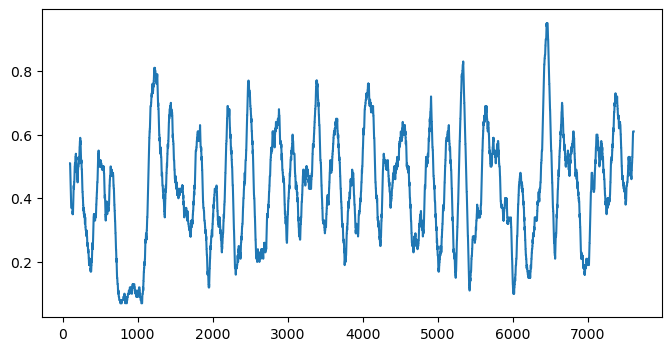

In [10]:
train_df["target"].rolling(window = 100).mean().plot(figsize = (8,4))

## 3.3 Example of positive

some positive (disaster) texts are shown below. There are varieties of disaster such as wildfire, heat wave, Annihlation, etc. There are some problems in texts. Spelling is not clean, Symbol and word are connected, a lot of numbers are seen, etc.

In [11]:
pos_idx = train_df["target"] == 1

print(train_df["text"].loc[pos_idx].iloc[5])
print(train_df["text"].loc[pos_idx].iloc[10])
print(train_df["text"].loc[pos_idx].iloc[115])
print(train_df["text"].loc[pos_idx].iloc[1110])
print(train_df["text"].loc[pos_idx].iloc[1210])

#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
Three people died from the heat wave so far
:StarMade: :Stardate 3: :Planetary Annihilation:: http://t.co/I2hHvIUmTm via @YouTube
Real people. True stories. Real pain &amp; suffering. #displaced #RefugeesMatter #Syria  https://t.co/OEZ7O9AB2C
#Earthquake #Sismo M 1.9 - 15km E of Anchorage Alaska: Time2015-08-06 00:11:16 UTC2015-08-05 16:11:16 -08:00 ... http://t.co/Z0VeR1hVM9


## 3.4 NaN

There are no NaN in `text` of train and test. 30% of `location` is NaN in text and target. 

In [12]:
train_df.isna().mean()

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [13]:
test_df.isna().mean()

id          0.000000
keyword     0.007968
location    0.338645
text        0.000000
dtype: float64

**fill NaN**

not usef for ML

In [14]:
filter1 = train_df["keyword"].isna()
train_df.loc[filter1, "keyword"] = "None"

filter1 = test_df["keyword"].isna()
test_df.loc[filter1, "keyword"] = "None"

filter1 = train_df["location"].isna()
train_df.loc[filter1, "location"] = "None"

filter1 = test_df["location"].isna()
test_df.loc[filter1, "location"] = "None"

## Conclusion of EDA

The label is slightly umbalanced, so **class weights** must be defined for ML. There are NaN in `location` and `keyword`, but these columns will not be used in ML, because I would like to achieve my goal by RNN without additional information. 

# 4. Data Cleaning by NLTK

## Tokenize
Text needs to be split to use RNN. `nltk.word_tokenize` can split sentence by space and symbols. 

In [15]:
text_df = pd.concat([train_df["text"], test_df["text"]]).reset_index()["text"]

In [16]:
tokenized = text_df.str.lower().apply(lambda x: nltk.word_tokenize(x))

**result of tokenize**

Texts are split successfully, but it contains lots of unnecessary symbols. They shall be removed. 

In [17]:
print("Original text")
print(train_df["text"].iloc[5])
print("Tokenized text")
print(tokenized[5])

Original text
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
Tokenized text
['#', 'rockyfire', 'update', '=', '>', 'california', 'hwy', '.', '20', 'closed', 'in', 'both', 'directions', 'due', 'to', 'lake', 'county', 'fire', '-', '#', 'cafire', '#', 'wildfires']


## Stem

Next step is to stem by `nltk.SnowballStemmer`. Stemmer can unify similar words, and it decreases number of unique words so that ML will be more efficient. In addition, stop words needs to be removed from tokenized texts. 

In [18]:
stemmer = nltk.SnowballStemmer("english")

**Examples of Stem**

Stem of 'disaster' and 'country'. 

In [19]:
print(stemmer.stem("disaster"))
print(stemmer.stem("disasters"))
print(stemmer.stem("disaste"))

disast
disast
disast


In [20]:
print(stemmer.stem("countries"))
print(stemmer.stem("country"))

countri
countri


In [21]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [22]:
def word_list_clean(word_list):
    
    output = []
    for w in word_list:
        if (w not in stopwords) and (w.isalpha()):
            #w_convert = WNlemma.lemmatize(w)
            w_convert = stemmer.stem(w)
            output.append(w_convert)
    
    return output

In [23]:
tokenized_clean = tokenized.apply(lambda x: word_list_clean(x))

In [24]:
print("Original text")
print(train_df["text"].iloc[5])
print("Cleaned text")
print(tokenized_clean[5])

Original text
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
Cleaned text
['rockyfir', 'updat', 'california', 'hwi', 'close', 'direct', 'due', 'lake', 'counti', 'fire', 'cafir', 'wildfir']


## Create Matrix

The final step is to replace unique words with integers, and create matrix from tokenized list. 

In [25]:
#original words : w_set
w_list = []
for WL in tokenized_clean:
    w_list += WL  
    
w_set = set(w_list)

In [26]:
#w_dic: word -> integer
#w_dic_inv: integer -> word (used for analysis)
w_dic = {}
w_dic_inv = {}
count = 1
for w in w_set:
    w_dic[w] = count
    w_dic_inv[count] = w
    count += 1

In [27]:
#convert word into integer: w_num_list
w_num_list = []
for WL in tokenized_clean:
    w_id_list = []
    for w in WL:
        w_id_list.append(w_dic[w])
        
    w_num_list.append(w_id_list)

In [28]:
#check max length of list
length_array = tokenized_clean.apply(lambda x: len(x)).to_numpy()
max_L = np.max(length_array)
max_L

22

In [29]:
#create matrix from list 

w_mat =  np.zeros((tokenized_clean.shape[0], max_L) ,dtype = int)

for i in range(len(w_num_list)):
    w_num_i = w_num_list[i]
    for j in range(len(w_num_i)):
        w_mat[i,j] = w_num_i[j]
        
w_max = w_mat.max()

**Result**

Tokenized texts are converted to integer matrix as follows. 

In [30]:
w_mat

array([[ 5601,  5550, 10974, ...,     0,     0,     0],
       [ 5304, 11289, 14161, ...,     0,     0,     0],
       [  631,  8401, 10065, ...,     0,     0,     0],
       ...,
       [ 4395,  4415,  2889, ...,     0,     0,     0],
       [12619,  8645,  8543, ...,     0,     0,     0],
       [ 9638, 13907,  2375, ...,     0,     0,     0]])

max integer and max length are necessary for RNN. 

In [31]:
print("max integer is ", w_max)
print("max length of sentence is", max_L)

max integer is  14942
max length of sentence is 22


# 5. Model

In this project three models are compared.

**models**
* **model1: SimpleRNN**
* **model2: GRU**
* **model3: GRU with 50% dropout**


**common elements**

Following elements are common in three models.

* Embedding layer
* Sigmoid output

Embedding layer is learnable parameter. It will be latent feature of words in vector form. 


## 5.1 Split Data

15% of trained data is selected randomly for validation set. 

In [32]:
y_all = train_df["target"].to_numpy()

In [33]:
train_idx_all = np.arange(n_train)

np.random.seed(1)
np.random.shuffle(train_idx_all)

#set train size 
n_train2 = int(n_train*0.85)

#select index from shuffled array
train_idx = train_idx_all[:n_train2]
val_idx = train_idx_all[n_train2:]

#split matrix
X_train = w_mat[train_idx,:]
X_val = w_mat[val_idx,:]
y_train = y_all[train_idx]
y_val = y_all[val_idx]
pos_weight = 0.5/np.mean(y_train)
class_weights = {0:1, 1:pos_weight}

In [34]:
np.mean(y_val), np.mean(y_train)

(0.4457092819614711, 0.4268273837119456)

In [35]:
X_test = w_mat[n_train:,:]

## 5.2 Functions

Predict function `pred_yhat`, and plot score function `plot_scores` are below.

In [36]:
def pred_yhat(model, X):
    #it returns prediction in integer (0 or 1)
    yhat = model.predict(X)
    yhat = (yhat > 0.5).astype(int)
    return yhat

In [37]:
def plot_scores(history):
    #it shows train and val accuracy and loss
    fig, ax = plt.subplots(1,2, figsize = (12, 5))
    ax[0].plot(history.history["accuracy"], label = "train")
    ax[0].plot(history.history["val_accuracy"], label = "val")
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("accuracy")
    ax[0].set_ylim([0.7,1])
    ax[0].set_title("Accuracy")
    ax[0].legend()

    ax[1].plot(history.history["loss"], label = "train")
    ax[1].plot(history.history["val_loss"], label = "val")
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("loss")
    ax[1].set_ylim([0,1])
    ax[1].set_title("Loss")
    ax[1].legend()
    
    plt.show()

## 5.3 Model1


In [38]:
def create_model1():
    sentence_indices = layers.Input(shape=(max_L,))

    X = layers.Embedding(w_max+1, 64, input_length=max_L)(sentence_indices)
    X = layers.SimpleRNN(128, return_sequences=False,  kernel_initializer = glorot_uniform(seed=1))(X)
    X = layers.Dense(1, activation = "sigmoid",  kernel_initializer = glorot_uniform(seed=1))(X)
    model1 = models.Model(inputs  = sentence_indices, outputs = X)
    model1.summary()
    
    return model1

In [39]:
model1 = create_model1()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22)]              0         
                                                                 
 embedding (Embedding)       (None, 22, 64)            956352    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               24704     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 981,185
Trainable params: 981,185
Non-trainable params: 0
_________________________________________________________________


In [40]:
model1.compile(loss='binary_crossentropy',optimizer= "adam",metrics=['accuracy'])

In [41]:
history1 = model1.fit(X_train, y_train, epochs=10, batch_size = 128, validation_data = (X_val, y_val), class_weight=class_weights)

Epoch 1/10
51/51 [==============================] - 4s 37ms/step - loss: 0.6084 - accuracy: 0.7116 - val_loss: 0.4700 - val_accuracy: 0.7925
Epoch 2/10
51/51 [==============================] - 2s 35ms/step - loss: 0.3183 - accuracy: 0.8883 - val_loss: 0.5138 - val_accuracy: 0.7688
Epoch 3/10
51/51 [==============================] - 2s 35ms/step - loss: 0.1629 - accuracy: 0.9524 - val_loss: 0.6028 - val_accuracy: 0.7688
Epoch 4/10
51/51 [==============================] - 2s 35ms/step - loss: 0.1004 - accuracy: 0.9700 - val_loss: 0.7381 - val_accuracy: 0.7452
Epoch 5/10
51/51 [==============================] - 2s 35ms/step - loss: 0.0786 - accuracy: 0.9753 - val_loss: 0.6645 - val_accuracy: 0.7802
Epoch 6/10
51/51 [==============================] - 2s 35ms/step - loss: 0.0666 - accuracy: 0.9768 - val_loss: 0.7214 - val_accuracy: 0.7636
Epoch 7/10
51/51 [==============================] - 1s 29ms/step - loss: 0.0593 - accuracy: 0.9768 - val_loss: 0.7732 - val_accuracy: 0.7382
Epoch 8/10
51

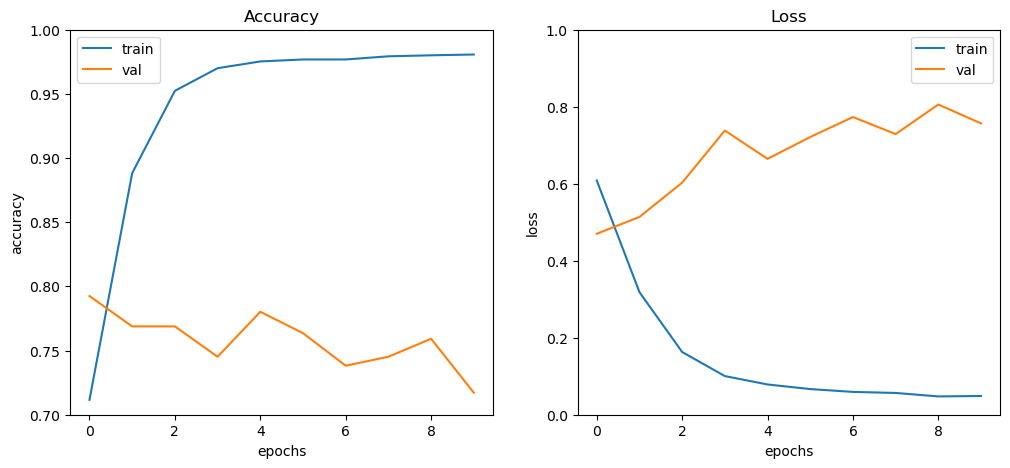

In [42]:
plot_scores(history1)

## 5.4 Model2

In [43]:
def create_model2():
    sentence_indices = layers.Input(shape=(max_L,))

    X = layers.Embedding(w_max+1, 64, input_length=max_L)(sentence_indices)
    X = layers.GRU(64*2, return_sequences=False,  kernel_initializer = glorot_uniform(seed=1))(X)
    X = layers.Dense(1, activation = "sigmoid",  kernel_initializer = glorot_uniform(seed=1))(X)
    model2 = models.Model(inputs  = sentence_indices, outputs = X)
    model2.summary()
    
    return model2

In [44]:
model2 = create_model2()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 22)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 22, 64)            956352    
                                                                 
 gru (GRU)                   (None, 128)               74496     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,030,977
Trainable params: 1,030,977
Non-trainable params: 0
_________________________________________________________________


In [45]:
model2.compile(loss='binary_crossentropy',optimizer= "adam",metrics=['accuracy'])

In [46]:
history2 = model2.fit(X_train, y_train, epochs=10, batch_size = 128, validation_data = (X_val, y_val), class_weight=class_weights)

Epoch 1/10
51/51 [==============================] - 6s 57ms/step - loss: 0.7428 - accuracy: 0.5586 - val_loss: 0.6904 - val_accuracy: 0.5543
Epoch 2/10
51/51 [==============================] - 2s 47ms/step - loss: 0.7424 - accuracy: 0.5732 - val_loss: 0.6898 - val_accuracy: 0.5543
Epoch 3/10
51/51 [==============================] - 2s 46ms/step - loss: 0.5968 - accuracy: 0.7181 - val_loss: 0.4465 - val_accuracy: 0.7951
Epoch 4/10
51/51 [==============================] - 2s 46ms/step - loss: 0.3468 - accuracy: 0.8717 - val_loss: 0.4406 - val_accuracy: 0.8091
Epoch 5/10
51/51 [==============================] - 2s 46ms/step - loss: 0.2156 - accuracy: 0.9295 - val_loss: 0.5575 - val_accuracy: 0.7890
Epoch 6/10
51/51 [==============================] - 2s 46ms/step - loss: 0.1550 - accuracy: 0.9518 - val_loss: 0.6645 - val_accuracy: 0.7706
Epoch 7/10
51/51 [==============================] - 2s 45ms/step - loss: 0.1102 - accuracy: 0.9677 - val_loss: 0.6569 - val_accuracy: 0.7636
Epoch 8/10
51

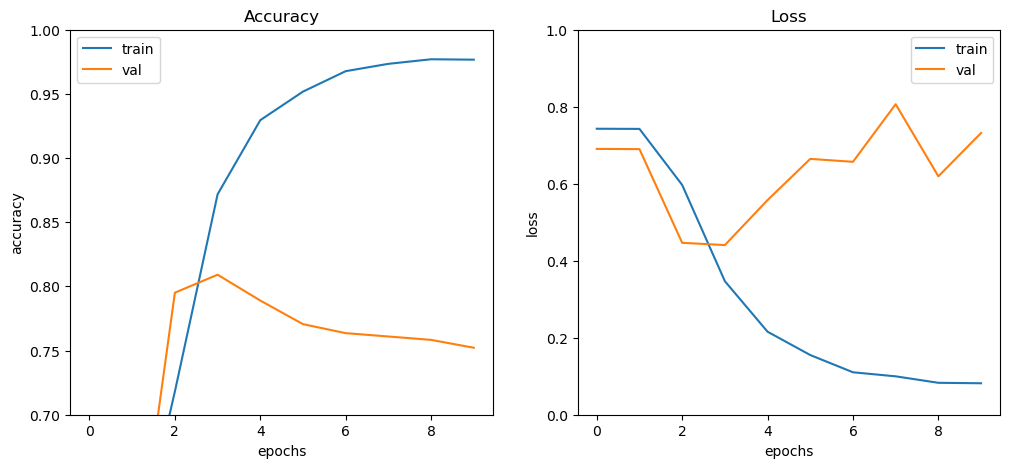

In [47]:
plot_scores(history2)

## 5.5 Model3

In [48]:
def create_model3():
    sentence_indices = layers.Input(shape=(max_L,))

    X = layers.Embedding(w_max+1, 64, input_length=max_L)(sentence_indices)
    X = layers.GRU(64*2, return_sequences=False,  kernel_initializer = glorot_uniform(seed=1), dropout = 0.5, recurrent_dropout = 0.5)(X)

    #X = layers.Dropout(0.5, seed = 1)(X)

    X = layers.Dense(1, activation = "sigmoid",  kernel_initializer = glorot_uniform(seed=1))(X)
    model3 = models.Model(inputs  = sentence_indices, outputs = X)
    model3.summary()
    
    return model3

In [49]:
model3 = create_model3()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 22)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 22, 64)            956352    
                                                                 
 gru_1 (GRU)                 (None, 128)               74496     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,030,977
Trainable params: 1,030,977
Non-trainable params: 0
_________________________________________________________________


In [50]:
model3.compile(loss='binary_crossentropy',optimizer= "adam",metrics=['accuracy'])

In [51]:
history3 = model3.fit(X_train, y_train, epochs=10, batch_size = 128, validation_data = (X_val, y_val), class_weight=class_weights)

Epoch 1/10
51/51 [==============================] - 7s 81ms/step - loss: 0.7420 - accuracy: 0.5704 - val_loss: 0.6883 - val_accuracy: 0.5543
Epoch 2/10
51/51 [==============================] - 4s 73ms/step - loss: 0.6999 - accuracy: 0.6246 - val_loss: 0.4886 - val_accuracy: 0.7574
Epoch 3/10
51/51 [==============================] - 4s 78ms/step - loss: 0.4566 - accuracy: 0.8212 - val_loss: 0.4455 - val_accuracy: 0.8074
Epoch 4/10
51/51 [==============================] - 4s 72ms/step - loss: 0.3218 - accuracy: 0.8838 - val_loss: 0.4700 - val_accuracy: 0.7846
Epoch 5/10
51/51 [==============================] - 4s 73ms/step - loss: 0.2493 - accuracy: 0.9204 - val_loss: 0.4863 - val_accuracy: 0.7820
Epoch 6/10
51/51 [==============================] - 4s 72ms/step - loss: 0.1838 - accuracy: 0.9425 - val_loss: 0.5531 - val_accuracy: 0.7662
Epoch 7/10
51/51 [==============================] - 4s 72ms/step - loss: 0.1657 - accuracy: 0.9487 - val_loss: 0.5921 - val_accuracy: 0.7758
Epoch 8/10
51

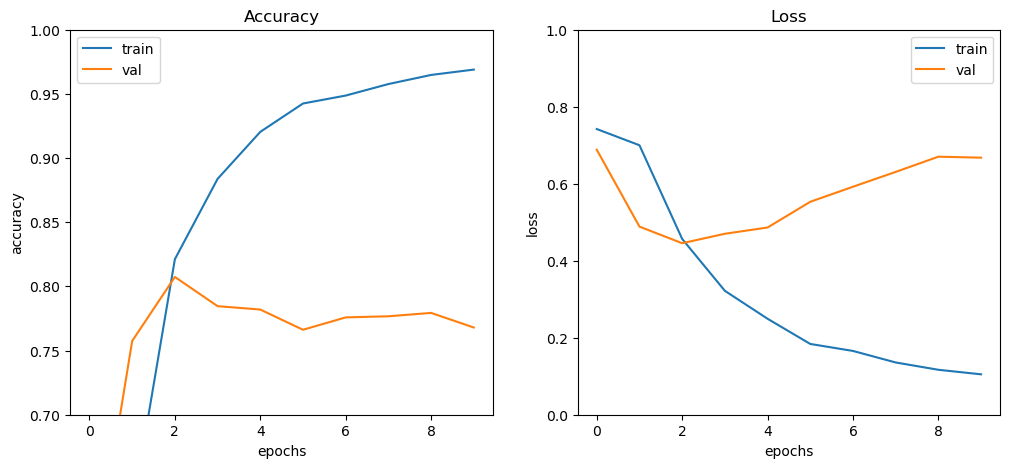

In [52]:
plot_scores(history3)

## 5.6 Results

According to validation result, the best model is **model 3 (GRU with 50% dropout)**, and the **best epoch = 3** for this model .

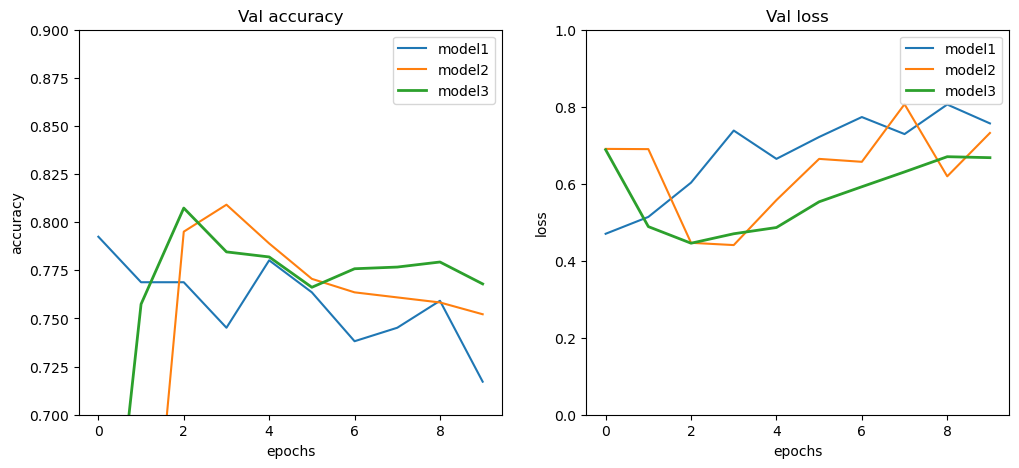

In [53]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
ax[0].plot(history1.history["val_accuracy"], label = "model1")
ax[0].plot(history2.history["val_accuracy"], label = "model2")
ax[0].plot(history3.history["val_accuracy"], label = "model3", lw = 2)
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("accuracy")
ax[0].set_ylim([0.7,0.9])
ax[0].set_title("Val accuracy")
ax[0].legend()


ax[1].plot(history1.history["val_loss"], label = "model1")
ax[1].plot(history2.history["val_loss"], label = "model2")
ax[1].plot(history3.history["val_loss"], label = "model3", lw = 2)
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")
ax[1].set_ylim([0,1])
ax[1].set_title("Val loss")
ax[1].legend()

plt.show()


**Submission**

Model 3 is created and trained with full data. It achieved Kaggle Score approx 0.8. 

In [54]:
model = create_model3()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 22)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 22, 64)            956352    
                                                                 
 gru_2 (GRU)                 (None, 128)               74496     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,030,977
Trainable params: 1,030,977
Non-trainable params: 0
_________________________________________________________________


In [55]:
pos_weight1 = 0.5/np.mean(y_all)
class_weights1 = {0:1, 1:pos_weight1}
class_weights1

{0: 1, 1: 1.1637114032405993}

In [56]:
model.compile(loss='binary_crossentropy',optimizer= "adam",metrics=['accuracy'])

In [57]:
model.fit(w_mat[:n_train], y_all, epochs=3, batch_size = 128, class_weight=class_weights1)

Epoch 1/3
60/60 [==============================] - 8s 74ms/step - loss: 0.7402 - accuracy: 0.5686
Epoch 2/3
60/60 [==============================] - 4s 67ms/step - loss: 0.6836 - accuracy: 0.6339
Epoch 3/3
60/60 [==============================] - 4s 68ms/step - loss: 0.4535 - accuracy: 0.8221


In [58]:
yhat_test = pred_yhat(model, X_test)
np.mean(yhat_test)

102/102 [==============================] - 1s 6ms/step


0.3536622739809991

In [59]:
sample_df["target"] = yhat_test
sample_df.to_csv('submission.csv',index=False)

# 6. Analysis: Checking similar words 

**Embedding layer** of the model represents latent feature of words in vector. If the model learned data properly, it may be possible to find similar words. In this chapter, words similar to `disaster` and `fire` are shown. Top 30 words are selected according to **Cosine Similarity**.  

In [60]:
emb_mat = model.layers[1].get_weights()[0]

In [61]:
abs_array =  np.sqrt(np.sum(np.square(emb_mat), axis = 1))

In [62]:
def similar_words(w_id, n = 30):
    w_abs = np.sqrt(np.sum(np.square(emb_mat[w_id,:])))
    divider =  w_abs*abs_array
    
    #Cos similarity
    vals = np.matmul(emb_mat[w_id,:], emb_mat.T)/divider
    
    #Sort values 
    top = np.argsort(vals)[::-1][1:(n+1)]
    
    
    #extract top words
    top_words = []
    for idx in top:
        top_words.append(w_dic_inv[idx])
        
    return top_words

### Words similar to `disaster`

Most of words evoke disaster.

In [63]:
top_words2 = similar_words(w_dic["disast"], 30)
print(top_words2)

['california', 'wildfir', 'crew', 'bomb', 'murder', 'northern', 'memori', 'expert', 'victim', 'bridg', 'costlier', 'airplan', 'legionnair', 'disea', 'villag', 'hiroshima', 'pm', 'wmata', 'outbreak', 'train', 'toward', 'migrant', 'drought', 'trench', 'flood', 'island', 'stem', 'mosqu', 'cdt', 'found']


### Words similar to `fire`

Words closely related to fire are extracted. 

In [64]:
top_words1 = similar_words(w_dic["fire"], 30)
print(top_words1)

['migrant', 'hiroshima', 'debri', 'northern', 'crew', 'wildfir', 'villag', 'malaysia', 'bomb', 'turkey', 'shot', 'outrag', 'bestnaijamad', 'isra', 'spill', 'coach', 'visit', 'rescuer', 'evacu', 'passeng', 'outbreak', 'helicopt', 'hailstorm', 'crime', 'earthquak', 'central', 'trench', 'abc', 'expert', 'costlier']


# 7. Conclusion


**GRU has better accuracy than simple RNN**

In this project, accuracy of GRU is about 2% higher than simple RNN. Simple RNN had strong overfit. Train accuracy goes high faster than GRU while val accuracy of simple RNN did not improve at all. Simple RNN with epoch 1 had 0.78 in Kaggle score whereas GRU (with drop out) had 0.8. 

**Regularization works well**

50% drop out for GRU works well to mitigate overfit, but still it overfits as training repeated. Therefore, early stop at epoch 3 is selected. Then f1 score 0.8 is achieved. 

**Possible to visualize trained model**

Embedded layer of trained model can extract words similar to specified word. It is evidence of proper training. It is possible to use pre-trained Embedded layer, but I did not use it for this project, because there are lots of miss-spelling in tweets. 